# Learn Tensorflow via a linear regression model
In this excercise, you will learn tensorflow in steps. Please use python 3 and tensorflow >=1.4.0. 

In [1]:
# A bit of setup

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%load_ext tensorboard


## Tensorflow graph

In the first step, we check the computation graph with a simple example. 

### <span style="color:red">Question 1 (4 points):</span>
Please run the code in the cell below and check the computation graph generated by `tensorboard`. 
1. What do the three ovals represent? 
2. Uncomment `x = 3` below and check the graph again. Don't forget to use the dropdown menu to select your latest run. Explain why the computation graph is different with the previous one. 

Write your answer below. 

Answer: 
1. The three ovals represent how x changes each time in the loop of my_func( ). Each oval means each operation for x in loop.  
2. The previous graph doesn't have the three ovals add, add_1, add_2, the y for them, and the oval x. They're different because in the previous run, x is just initialized by tf.constant. After being uncommentted, x is 3 after initialized. So there're three ovals.

In [27]:
from datetime import datetime

# The function to be traced.
@tf.function
def my_func(x):
  "A simple function"

  for i in range(3):
    x = x + 2

  return x

# Set up logging.
logdir="runs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(logdir)

# initialize the argument
x = tf.constant(3)
x = 3 # TODO: uncomment this line and check the difference

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)

# Call only one tf.function when tracing.
output = my_func(x)

with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

In [35]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 98931), started 0:00:19 ago. (Use '!kill 98931' to kill it.)

In [34]:
!kill 96063

/bin/sh: line 0: kill: (96063) - No such process


## Learn Tensorflow through a linear regression model

In this task, you will learn `tensorflow` through a logistic regression model. 
### <span style="color:red">Question 2 (4 points):</span>
You need to run all cells below and make necessary changes to avoid errors. At the end, you will get a regression model trained. 

### Tensorflow basics
Tensorflow use tensors to store scalars, vectors, matrices, and tensors. Here is the introduction webpage of tensorflow: https://www.tensorflow.org/guide/tensor . The few cells below show you a few simple operations on tensorflow arrays. 

In [118]:
# Get the shape of a tensor: 

a = tf.constant([1, 2, 3], dtype=tf.float32)

print('a has shape: ', a.get_shape())


# indexing in tensors is similar to numpy arrays

b = tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)

print('b[:, 1] is: ')
print(b[:, 1])

print('b[0] is: ')
print(b[0])


a has shape:  (3,)
b[:, 1] is: 
tf.Tensor([2. 5.], shape=(2,), dtype=float32)
b[0] is: 
tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)


In [119]:
# take the sum along a dimension 

print('Sum up b along rows:', tf.reduce_sum(b, axis=1)) # the `axis` specifies the dimension to be ``reduced''

# reduce two dimensions in a summation 
print('Sum up b along rows:', tf.reduce_sum(b, axis=[0, 1])) # the `axis` specifies the dimension to be ``reduced''

# similar functions are tf.reduce_max, tf.reduce_logsumexp


Sum up b along rows: tf.Tensor([ 6. 15.], shape=(2,), dtype=float32)
Sum up b along rows: tf.Tensor(21.0, shape=(), dtype=float32)


In [120]:
# matrix multiplication 

c = tf.constant([[2, 2, 2]]) 

# Use this line, otherwise it doesn't work.
c = tf.constant([[2], [2], [2]], dtype=tf.float32) 

print('c has shape: ', c.get_shape())

print(tf.matmul(b, c))


c has shape:  (3, 1)
tf.Tensor(
[[12.]
 [30.]], shape=(2, 1), dtype=float32)


### Implement  functions for a linear regression model 

### <span style="color:red">Question 3 (4 points):</span>
Please implement a linear regression model in `implementation.regression_func`. The empty function has detailed instructions. 

In [121]:
from implementation import regression_func

x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)
w = tf.constant([1, 1], dtype=tf.float32)
b = tf.constant(0.2, dtype=tf.float32)

y_hat = regression_func(x, w, b)

print(y_hat.numpy())
print(y_hat.get_shape())

# y_hat should be [3.2, 7.2]

[3.2 7.2]
(2,)


### <span style="color:red">Question 4 (4 points):</span>

Please implement a loss function in  `implementation.loss_func`. The empty function has detailed instructions.

In [122]:
from implementation import loss_func

# fix an issue in this line, otherwise it does not work with the loss function
y = tf.constant([3, 7], dtype=tf.float32)

loss = loss_func(y, y_hat)

print(loss)

# the loss should be 0.08



tf.Tensor(0.07999994, shape=(), dtype=float32)


Calculate gradient with `tf.GradientTape`

In [123]:
with tf.GradientTape() as gt:
    gt.watch([w, b])
    y_hat = regression_func(x, w, b)

dy_dwb = gt.gradient(y_hat, [w, b]) 

# gradient with respect to w and b
print(dy_dwb)

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 6.], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>]


Update parameters with an optimizer

In [124]:
# note that the learning rate is 1.0
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0)

# You can update a tf.Variable, but not a tf.Tensor
# Can you fix the following to lines?
w = tf.Variable([1.0, 1.0], dtype=tf.float32)
b = tf.Variable(1.0, dtype=tf.float32)


dw = tf.Variable([0.1, 0.2], dtype=tf.float32)
db = tf.Variable(0.3, dtype=tf.float32)

optimizer.apply_gradients(zip([dw, db], [w, b]))

# Check the result below. Note that the calculation is: w <- w - dw * learning_rate; 
# it is subtraction, not addtion.
print(w)
print(b)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.9, 0.8], dtype=float32)>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7>


### Train the regression model

Now we can implement a regression model. We use data with one feature only so we can plot the data easily. Assume the feature matrix is `x_np` and the label is `y_np`. 


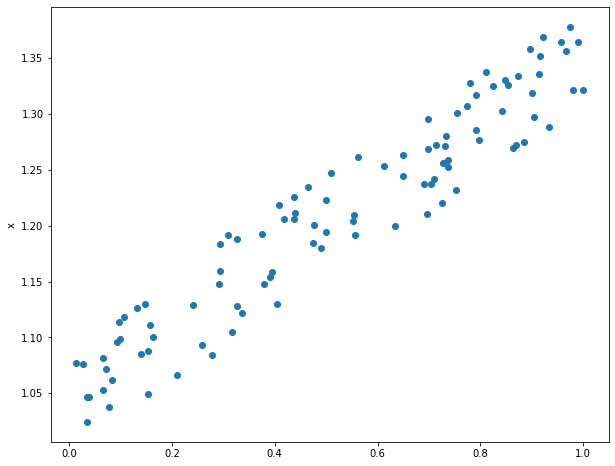

In [39]:
# plot the data before fitting the model. 
# numpy values
N = 100
x_np = np.random.random_sample([N, 1]).astype(np.float32)
y_np = (np.squeeze(x_np.dot([[0.3]])) + 1.0 + 0.1 * np.random.random_sample([N])).astype(np.float32)

plt.plot(np.squeeze(x_np), y_np, 'o')
plt.ylabel('y')
plt.ylabel('x')
plt.show()


In [40]:
print(x_np.shape)

(100, 1)


### <span style="color:red">Question 5 (4 points):</span>
Please implement the `implementation.train_lr` function, which trains a linear regression model.  

In [43]:
from implementation import train_lr

lamb = tf.constant(1.0, dtype=tf.float32)

w, b = train_lr(x=tf.constant(x_np), y=tf.constant(y_np), lamb=lamb)

print('(w, b) = ', (w.numpy(), b.numpy()))

# the result should be similar to (0.3, 1.0)

loss becomes 0.009942957 after 1 iteration
loss becomes 0.0008120425 after 101 iteration
loss becomes 0.0008120419 after 201 iteration
loss becomes 0.0008120419 after 301 iteration
loss becomes 0.0008120419 after 401 iteration
loss becomes 0.0008120419 after 501 iteration
loss becomes 0.0008120419 after 601 iteration
loss becomes 0.0008120419 after 701 iteration
loss becomes 0.0008120419 after 801 iteration
loss becomes 0.0008120419 after 901 iteration
(w, b) =  (array([0.27153936], dtype=float32), 1.0675696)


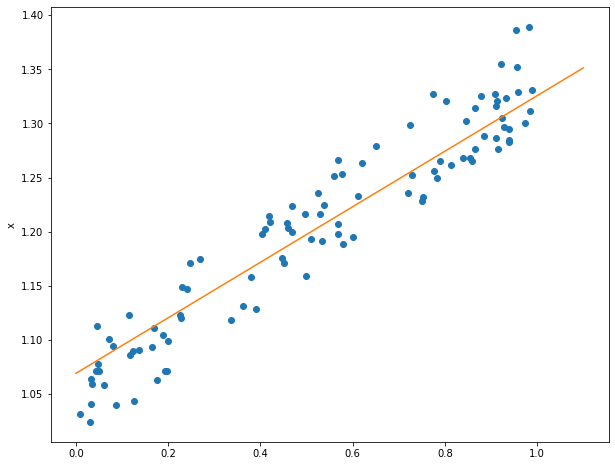

In [156]:
# Plot the result

w_np = w.numpy()
b_np = b.numpy()

x_line = np.arange(12) / 10.0
y_line = x_line * np.squeeze(w_np) + b_np

plt.plot(x_np, y_np, 'o')
plt.plot(x_line, y_line)
plt.ylabel('y')
plt.ylabel('x')
plt.show()
